In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import uncertainty_wizard as uwiz
from sklearn.model_selection import train_test_split


Training data:        (56000, 28, 28)
Training solution:    (56000,)
Test data:            (14000, 28, 28)
Test solution:        (14000,)


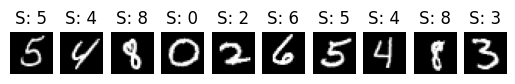

Training data:        (56000, 28, 28, 1)
Training solution:    (56000, 10)
Test data:            (14000, 28, 28, 1)
Test solution:        (14000, 10)


In [5]:
# LOAD
data  = pd.read_csv('mnist.csv')
x_all = data.drop('solution', axis=1).values
y_all = data['solution'].values

# RESHAPE
x_all_fixed = x_all.reshape(-1, 28, 28)

# SPLIT
x_train, x_test, y_train, y_test = train_test_split(x_all_fixed, y_all, test_size=0.2, random_state=42)


print("Training data:       ", x_train.shape)
print("Training solution:   ", y_train.shape)
print("Test data:           ", x_test.shape)
print("Test solution:       ", y_test.shape)

fig, axes = plt.subplots(1, 10)
for i in range(10):
    axes[i].imshow(x_train[i], cmap='gray', vmin=0, vmax=255)
    axes[i].set_title(f"S: {y_train[i]}")
    axes[i].axis('off')
plt.show()

x_train = (x_train.astype('float32') / 255).reshape(x_train.shape[0], 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
x_test  = (x_test.astype('float32') / 255).reshape(x_test.shape[0], 28, 28, 1)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes=10)      #??????????

print("Training data:       ", x_train.shape)
print("Training solution:   ", y_train.shape)
print("Test data:           ", x_test.shape)
print("Test solution:       ", y_test.shape)

RESHAPE
* Problem: csv x_all data is based on 784 pixels and must be formed to 28x28 pixels which is actual value
* REF: https://numpy.org/doc/stable/reference/generated/numpy.reshape.html

PLOT
* functions (imshow) from Matplotlib Documentation. 
* REF: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

* Adding a new dimension(1) for train and test, because the color is just black or white and no extra color.
* Divide with 255 so we can change the (0 - 255) to (0 or 1)

COMPILING...
SAVING SETTINGS...
INFO:tensorflow:Assets written to: model_settings/assets


INFO:tensorflow:Assets written to: model_settings/assets


FIT...
1575/1575 [==============================] - 27s 17ms/step - loss: 2.2379 - accuracy: 0.2469 - val_loss: 2.1407 - val_accuracy: 0.5711
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 uwiz_bernoulli_dropout (Uw  (None, 12, 12, 64)        0         
 izBernoulliDropout)                                             
                                                                 
 flatten (Flatten)           (None, 9216)     

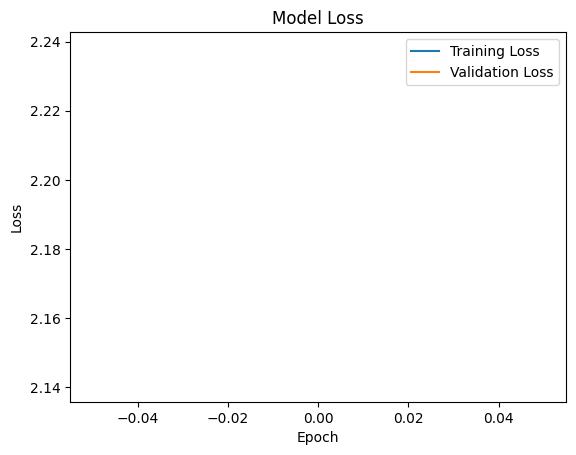

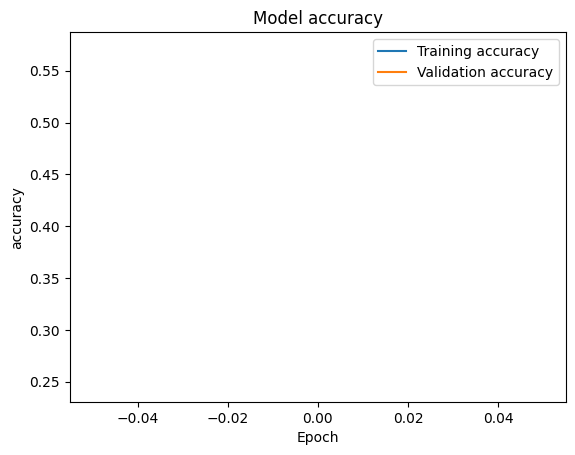

In [6]:

# model = tf.keras.models.Sequential()
model = uwiz.models.StochasticSequential()

# model.add(tf.keras.layers.Conv2D(filters, kernel_size=(size), activation='methods', input_shape=(shape info)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(tf.keras.layers.MaxPooling2D(pool_size=(max pooling height and width)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(tf.keras.layers.Dropout(fraction %)) 
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())

# model.add(tf.keras.layers.Dense(digits, activation='methods'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# COMPILE
print("COMPILING...")
model.compile(loss      = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adadelta(),
              metrics   = ['accuracy'])

# SAVING SETTINGS
print("SAVING SETTINGS...")
model.save("model_settings", save_format='tf')


# FIT
print("FIT...")
model_info = model.fit(x_train, y_train, 
                       validation_split = 0.1, 
                       batch_size       = 32, 
                       epochs           = 1,
                       verbose          = 1, 
                       callbacks        = [tf.keras.callbacks.EarlyStopping(patience=2)])

print(model.inner.summary())

# STEP 1
# keras.io
# keras.save.save to save the ai model settings
# keras.saving.load_model(filepath)
# - security check with load model

# STEP 2 AFTER LOADING
# uwiz.models.schochastic_from_keras(keras_models)


# PLOT
print("PLOT...")
plt.plot(model_info.history['loss']     , label='Training Loss')
plt.plot(model_info.history['val_loss'] , label='Validation Loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(model_info.history['accuracy']     , label='Training accuracy')
plt.plot(model_info.history['val_accuracy'] , label='Validation accuracy')

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Uncertainty Wizard
* Uncertainty Wizard sequential has same function as Keras sequential, but is specially made to handle uncertainty.

epochs

Layers Conv2D
* Convolutional layer that use the number of filter with different sizes to find different value from edges, corners and so on.

Layers MaxPooling2D
* Make the data more robust by splitting the 2d-block data and only keeping the highest value from each part.

Layers Dropout
* Prevent overfitting by having 50% droprate of unit during the traning of the model. It will help out with learn redundant learning and make the progress more robust.

Layers Flatten
* Flatten it out from 2D array to a 1D array.
* Doesn't affect batch size.

Layer Dense


438/438 [==============================] - 2s 4ms/step
(14000, 28, 28, 1)


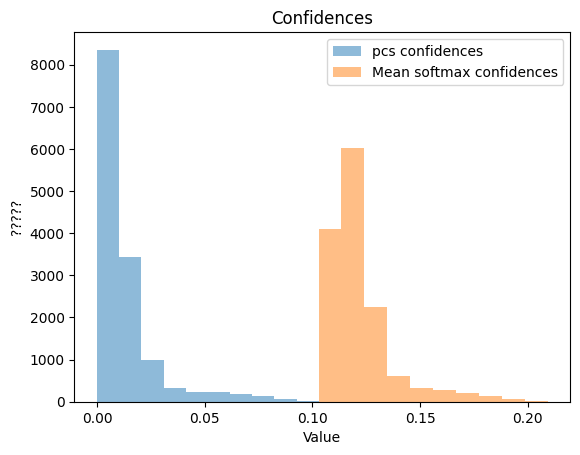

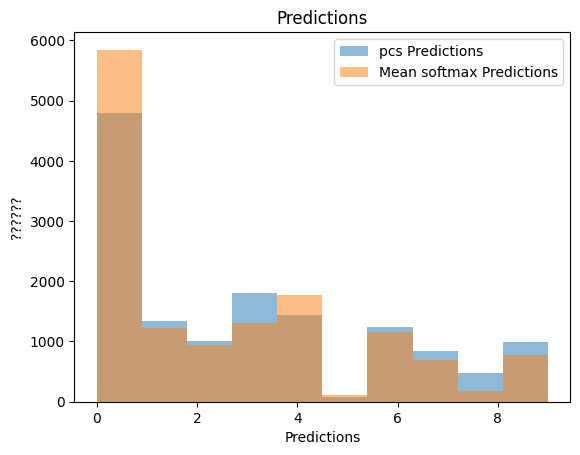

In [7]:
quantifiers = ['pcs', 'mean_softmax']
results = model.predict_quantified(x_test,
                                   quantifier   = quantifiers,
                                   batch_size   = 32,
                                   sample_size  = 32,
                                   verbose      = 1)

print(x_test.shape)
pcs_predictions = results[0][0]
pcs_confidences = results[0][1]
mean_softmax_predictions = results[1][0]
mean_softmax_confidences = results[1][1]

plt.hist(pcs_confidences, alpha=0.5, label='pcs confidences')
plt.hist(mean_softmax_confidences, alpha=0.5, label='Mean softmax confidences')
plt.xlabel('Value')
plt.ylabel('?????')
plt.title('Confidences')
plt.legend()
plt.show()

plt.hist(pcs_predictions, alpha=0.5, label='pcs Predictions')
plt.hist(mean_softmax_predictions, alpha=0.5, label='Mean softmax Predictions')
plt.xlabel('Predictions')
plt.ylabel('??????')
plt.title('Predictions')
plt.legend()
plt.show()

In [8]:
test_results = results[0][0]
with open('Archive.txt', 'w') as file:
    file.write(str(test_results))